In [1]:
pip install seaborn matplotlib

In [26]:
import keras
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
from sklearn import svm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from keras.models import Sequential
from tensorflow.keras import models, layers
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from keras. layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, cross_val_score
from keras.layers import Conv1D, MaxPooling2D, MaxPooling1D, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
  pass
  warnings.warn=ignore_warn

In [3]:
BATCH_SIZE = 32
IMAGE_SIZE = 300
CHANNELS=3
EPOCHS=98

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Final_Dataset(RLDD)",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1850 files belonging to 6 classes.


In [6]:
class_names = dataset.class_names
class_names

['Bacterial_leaf_blight',
 'Brown_spot',
 'Healthy_leaf',
 'Leaf_Blast',
 'Other',
 'Tungro']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 300, 300, 3)
[5 4 0 3 2 2 1 3 2 5 0 4 4 1 4 4 3 2 2 4 3 5 2 3 1 1 2 2 1 2 4 2]


In [8]:
new_image_size = (256, 256)
resized_dataset = dataset.map(lambda x, y: (tf.image.resize(x, new_image_size), y))
for image_batch, labels_batch in resized_dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


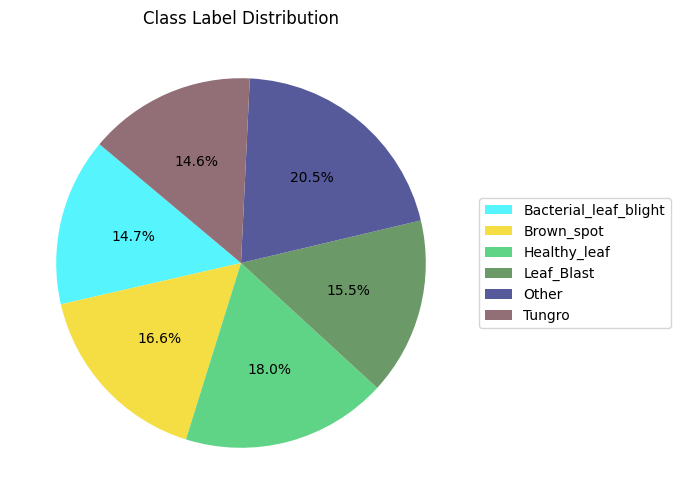

In [47]:
import random
# Assuming you have a list of colors corresponding to each class
class_colors = [f'#{random.randint(0, 0xFFFFFF):06x}' for _ in class_names]

class_counts = [0] * len(class_names)
for images_batch, labels_batch in resized_dataset:# resized_dataset
    for label in labels_batch:
        class_counts[label] += 1
plt.figure(figsize=(6, 6))
patches, texts, autotexts = plt.pie(class_counts,
                                   autopct='%1.1f%%', startangle=140, colors=class_colors)

plt.legend(patches, class_names, loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Class Label Distribution")
plt.show()

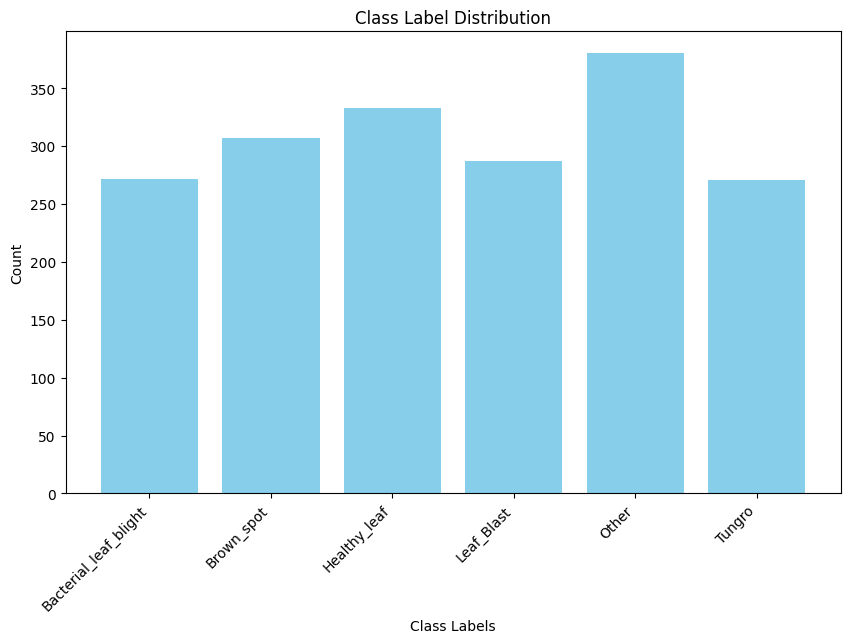

In [45]:
import matplotlib.pyplot as plt
import numpy as np

# Create a list to store the count of each class label
class_counts = [0] * len(class_names)
for images_batch, labels_batch in resized_dataset:
    for label in labels_batch:
        class_counts[label] += 1

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.title("Class Label Distribution")
plt.xlabel("Class Labels")
plt.ylabel("Count")
plt.xticks(rotation=45, ha="right")
plt.show()

(256, 256, 3)


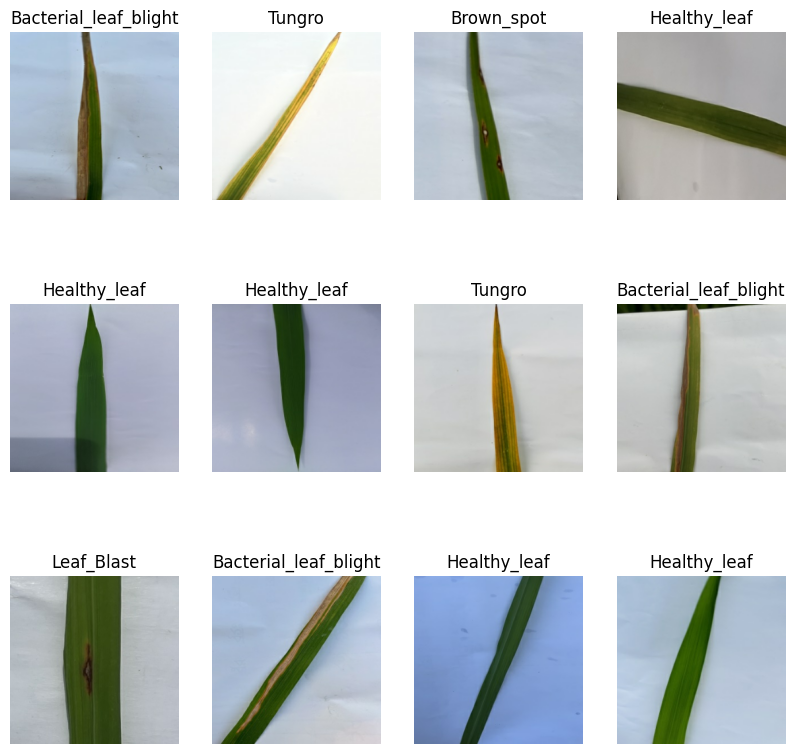

In [46]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in resized_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")
  print(image_batch[0].shape)

In [10]:
train_size = 0.8
len(resized_dataset)*train_size

46.400000000000006

In [11]:
train_ds= resized_dataset.take(46)
len(train_ds)

46

In [12]:
test_ds = resized_dataset.skip(46)
len(test_ds)

12

In [13]:
val_size = 0.1
len(resized_dataset)*val_size

5.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

6

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)
      train_size = int(train_split * ds_size)
      val_size = int(val_split * ds_size)
      train_ds = ds.take(train_size)
      val_ds = ds.skip(train_size).take(val_size)
      test_ds = ds.skip(train_size).skip(val_size)
      return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(resized_dataset)

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(256, 256),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [20]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",dtype=tf.float32),  # Explicitly set data type
    # ... other preprocessing layers
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.1),
  layers.experimental.preprocessing.RandomContrast(0.2),
])

In [21]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:
# Load MobileNetV3 with pre-trained weights
mobilenet_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(256, 256, CHANNELS))
for layer in mobilenet_model.layers:
    layer.trainable = False

mobileNetV3_model = tf.keras.Sequential([
    layers.Input(shape=(256, 256, CHANNELS)),
    data_augmentation,
    mobilenet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(6, activation='softmax')
])
mobileNetV3_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 8, 8, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 960)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 6)                 5766      
                                                                 
Total params: 3002118 (11.45 MB)
Trainable params: 5766 (22.52 KB)
Non-trainable params: 2996352 (11.43 MB)
_________________________________________________________________


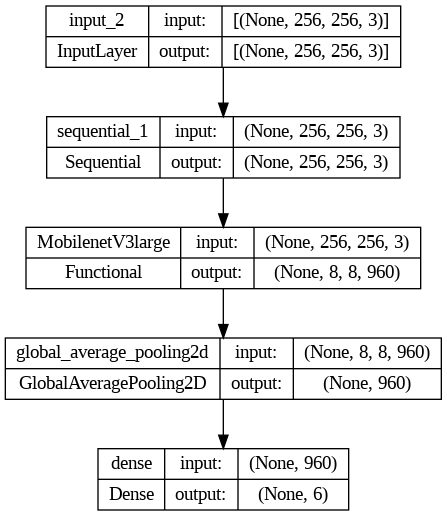

In [23]:
plot_model(mobileNetV3_model, to_file='mobilenet.png', show_shapes=True)

In [27]:
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True
    )

In [28]:
mobileNetV3_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [29]:
history = mobileNetV3_model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,#23
)

Epoch 1/98
46/46 [==============================] - 47s 654ms/step - loss: 1.0584 - accuracy: 0.6153 - val_loss: 0.4903 - val_accuracy: 0.8625
Epoch 2/98
46/46 [==============================] - 22s 488ms/step - loss: 0.4334 - accuracy: 0.8779 - val_loss: 0.2955 - val_accuracy: 0.9438
Epoch 3/98
46/46 [==============================] - 24s 515ms/step - loss: 0.3039 - accuracy: 0.9127 - val_loss: 0.2001 - val_accuracy: 0.9625
Epoch 4/98
46/46 [==============================] - 22s 478ms/step - loss: 0.2549 - accuracy: 0.9250 - val_loss: 0.1934 - val_accuracy: 0.9750
Epoch 5/98
46/46 [==============================] - 27s 584ms/step - loss: 0.2171 - accuracy: 0.9407 - val_loss: 0.1642 - val_accuracy: 0.9750
Epoch 6/98
46/46 [==============================] - 29s 630ms/step - loss: 0.1901 - accuracy: 0.9482 - val_loss: 0.1552 - val_accuracy: 0.9625
Epoch 7/98
46/46 [==============================] - 28s 603ms/step - loss: 0.1713 - accuracy: 0.9468 - val_loss: 0.1301 - val_accuracy: 0.9812

In [30]:
scores = mobileNetV3_model.evaluate(test_ds)
print(f"Test Accuracy: {round(scores[1],4)*100}%")

7/7 [==============================] - 6s 55ms/step - loss: 0.0446 - accuracy: 0.9821
Test Accuracy: 98.21%


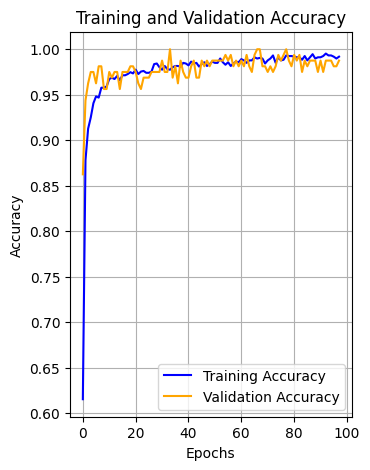

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
EPOCHS = len(acc)

plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy', color='blue')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy', color='orange')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

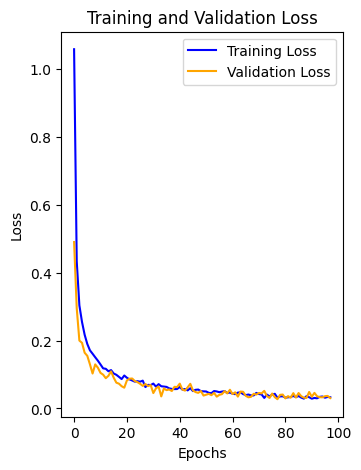

In [37]:
loss = history.history['loss']
val_loss = history.history['val_loss']
EPOCHS = len(loss)  # Assuming loss and val_loss have the same length
plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), loss, label='Training Loss', color='blue')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss', color='orange')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [39]:
# Make predictions using the model
predictions = mobileNetV3_model.predict(test_ds)
# Get the predicted class labels
predicted_labels = [np.argmax(prediction) for prediction in predictions]
test_labels = []
for images, labels in test_ds:
    test_labels.extend(labels.numpy())
test_labels = np.array(test_labels)
confusion = confusion_matrix(test_labels, predicted_labels)

print("Confusion Matrix:")
print(confusion)

7/7 [==============================] - 0s 51ms/step
Confusion Matrix:
[[15  2 11  4  3  3]
 [ 5 19  2  2  6  3]
 [ 9  3 26  5  7  4]
 [ 0  1  7 11  6  3]
 [ 7  7  5  4 10  3]
 [ 5  2  3  3  4 14]]


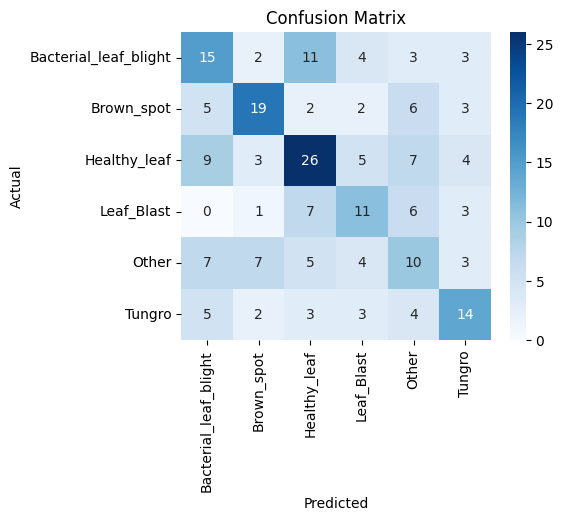

In [40]:
def plot_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function to display the confusion matrix
plot_confusion_matrix(confusion, class_names)

In [35]:
from sklearn.metrics import classification_report
test_labels = []  # True labels
predicted_labels = []  # Predicted labels

for images_batch, labels_batch in test_ds:
    batch_prediction = mobileNetV3_model.predict(images_batch)
    predicted_labels.extend(np.argmax(batch_prediction, axis=1))
    test_labels.extend(labels_batch.numpy())
report = classification_report(test_labels, predicted_labels, target_names=class_names)
print(report)

1/1 [==============================] - 0s 52ms/step
                       precision    recall  f1-score   support

Bacterial_leaf_blight       0.93      1.00      0.96        38
           Brown_spot       1.00      0.92      0.96        37
         Healthy_leaf       1.00      1.00      1.00        54
           Leaf_Blast       0.97      1.00      0.98        28
                Other       1.00      1.00      1.00        36
               Tungro       1.00      0.97      0.98        31

             accuracy                           0.98       224
            macro avg       0.98      0.98      0.98       224
         weighted avg       0.98      0.98      0.98       224



first image to predict
actual label: Brown_spot
1/1 [==============================] - 0s 52ms/step
predicted label: Brown_spot


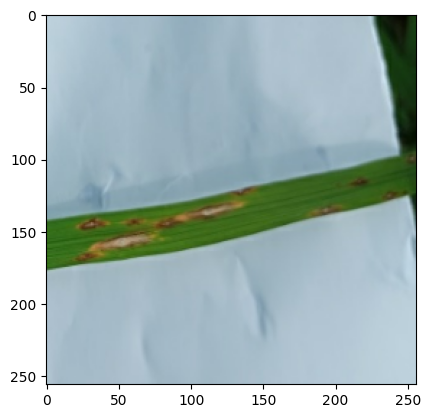

In [36]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = mobileNetV3_model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])